In [1]:
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

sns.set_theme()

In [2]:
path = "../processed/testing/perplexity/perplexity_498_18_03_2024.csv"
df = pd.read_csv(path)

In [3]:
z_threshold = 4.0
# Need to binary classify the results 

In [4]:
def gen_base_df(full_df):
    wm_col_text = "kgw-watermarked"
    wm_col_score = "kgw-wm-zscore"
    wm_col_ppl = wm_col_text + "-ppl"
    
    base_wmark_df = full_df[[wm_col_text, wm_col_score, wm_col_ppl]].copy()
    base_wmark_df["watermarked"] = [True for _ in range(len(base_wmark_df))]
    base_wmark_df = base_wmark_df.rename(columns={wm_col_text: "text", wm_col_score: "z-score", wm_col_ppl: "perplexity"})

    nwmark_col_text = "non-watermarked"
    nwmark_col_score = "non-wm-zscore"
    nwmark_col_ppl = nwmark_col_text + "-ppl"

    non_wmark_df = full_df[[nwmark_col_text, nwmark_col_score, nwmark_col_ppl]].copy()
    non_wmark_df["watermarked"] = [False for _ in range(len(non_wmark_df))]
    non_wmark_df = non_wmark_df.rename(columns={nwmark_col_text: "text", nwmark_col_score: "z-score", nwmark_col_ppl: "perplexity"})
    
    bc_df = pd.concat([base_wmark_df, non_wmark_df])
    bc_df['watermark-detected'] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)
    return bc_df

In [5]:
def gen_paraphrase_df(full_df, pp_type="para", pp_iter = 1, z_threshold = 4.0):
    wm_col_text = f"pp-kgw-{pp_type}-{pp_iter}"
    wm_col_score = f"kgw-{pp_type}-zscore-{pp_iter}"
    wm_col_sim = f"pp-kgw-{pp_type}-sim-{pp_iter}"
    wm_col_ppl = wm_col_text + "-ppl"
    
    wmark_df = full_df[[wm_col_text, wm_col_score, wm_col_sim, wm_col_ppl]]
    wmark_df = wmark_df.rename(columns={wm_col_text: "text", wm_col_score: "z-score", wm_col_sim: "similarity", wm_col_ppl: "perplexity"})
    wmark_df["watermarked"] = [True for _ in range(len(wmark_df))]
    
    nwmark_col_text = f"pp-unwatermarked-{pp_type}-{pp_iter}"
    nwmark_col_score = f"nowm-{pp_type}-zscore-{pp_iter}"
    nwmark_col_sim = f"pp-nowm-{pp_type}"
    nwmark_col_ppl = nwmark_col_text + "-ppl"

    nwmark_df = full_df[[nwmark_col_text, nwmark_col_score, nwmark_col_ppl]]
    nwmark_df = nwmark_df.rename(columns={nwmark_col_text: "text", nwmark_col_score: "z-score", wm_col_sim: "similarity", nwmark_col_ppl: "perplexity"})
    nwmark_df["watermarked"] = [False for _ in range(len(nwmark_df))]
    
    bc_df = pd.concat([wmark_df, nwmark_df])
    bc_df["watermark-detected"] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)
    return bc_df

In [6]:
image_output_path = "../results/roc/"

## ROC Plots

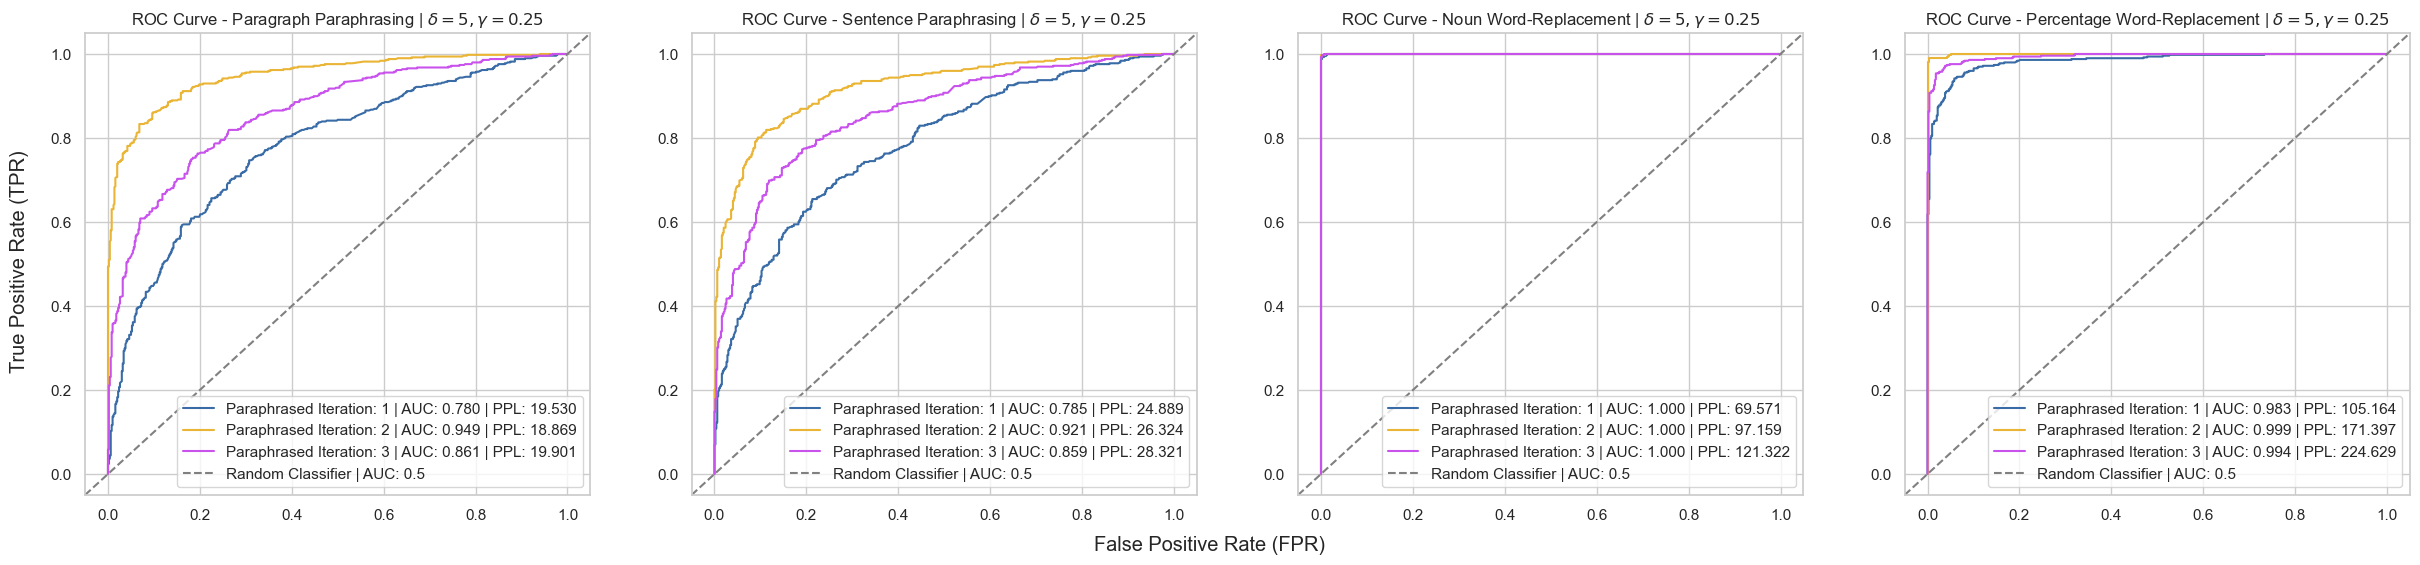

In [7]:
sns.set_theme(style='whitegrid')
fig, axs = plt.subplots(1, 4, figsize=(30, 6))

pp_types = ["para", "sent", "noun-word", "perc-word"]
pp_names = ["Paragraph Paraphrasing", "Sentence Paraphrasing", "Noun Word-Replacement", "Percentage Word-Replacement"]
color_scheme = ["#396ca6", "#eab434", "#c952ed"] 
no_paraphrases = 3

for i, ax in enumerate(axs):
    pp_type = pp_types[i]
    pp_name = pp_names[i]
    for j in range(1,4):
        pp_bc_df = gen_paraphrase_df(df, pp_type=pp_type, pp_iter=j)
        y_values, y_pred = pp_bc_df["watermarked"], pp_bc_df["z-score"]
        fpr, tpr, thresholds = roc_curve(y_values, y_pred)
        roc_auc = auc(fpr, tpr)
        ppl = pp_bc_df.perplexity.mean()
        ax.plot(fpr, tpr, label=f'Paraphrased Iteration: {j} | AUC: {roc_auc:.3f} | PPL: {ppl:.3f}', color = color_scheme[j-1]) 
    
    ax.axline((0,0), slope=1, linestyle='--', label="Random Classifier | AUC: 0.5", color='gray')
    # ax.set_xlim(0, 1.0001)
    # ax.set_ylim(0, 1.0001)
    
    ax.set_title(f"ROC Curve - {pp_name} | $\delta = 5, \gamma = 0.25$")
    ax.legend()

fig.supylabel("True Positive Rate (TPR)", x = 0.1)
fig.supxlabel("False Positive Rate (FPR)")

# plt.savefig(image_output_path+f"roc-curve-all.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [13]:
gen_base_df(df).columns

Index(['text', 'z-score', 'perplexity', 'watermarked', 'watermark-detected'], dtype='object')

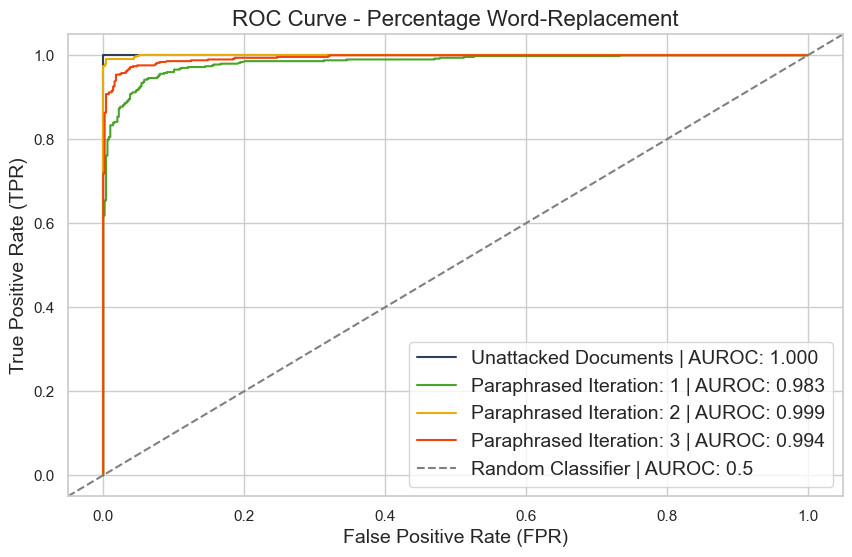

In [18]:
type_index = 3

sns.set_theme(style='whitegrid')
color_scheme = ["#48a528", "#e7ac0a", "#ed440c", "#2E4057"]
fig, axs = plt.subplots(figsize=(10, 6))

bc_df = gen_base_df(df)
y_values, y_pred = bc_df["watermarked"], bc_df["z-score"]
fpr, tpr, thresholds = roc_curve(y_values, y_pred)
roc_auc = auc(fpr, tpr)
axs.plot(fpr, tpr, label=f'Unattacked Documents | AUROC: {roc_auc:.3f}', color = color_scheme[3])

for i in range(1,4):
    pp_bc_df = gen_paraphrase_df(df, pp_type=pp_types[type_index], pp_iter=i)
    y_values, y_pred = pp_bc_df["watermarked"], pp_bc_df["z-score"]
    fpr, tpr, thresholds = roc_curve(y_values, y_pred)
    roc_auc = auc(fpr, tpr)
    axs.plot(fpr, tpr, label=f'Paraphrased Iteration: {i} | AUROC: {roc_auc:.3f}', color = color_scheme[i-1])

axs.axline((0,0), slope=1, linestyle='--', label="Random Classifier | AUROC: 0.5", color='gray')

axs.set_title(f"ROC Curve - {pp_names[type_index]}", fontsize=16)
axs.set_xlabel("False Positive Rate (FPR)", fontsize=14)
axs.set_ylabel("True Positive Rate (TPR)", fontsize=14)
plt.legend(loc='best', fontsize="14")

# plt.savefig(image_output_path+f"roc-curve-{pp_types[type_index]}.pdf", format="pdf", bbox_inches='tight', dpi=2400)
plt.show()

## Table Stats | TPR, FNR, Similarity, PPL

### Unattacked Documents

In [97]:
from sklearn.metrics import confusion_matrix
base_df = gen_base_df(df)

tn, fp, fn, tp = confusion_matrix(base_df["watermarked"], base_df["watermark-detected"]).ravel()
tpr = tp / (fn + tp)
tnr = tn / (tn + fp) 

ppl = base_df.perplexity.mean()

print(f"TPR: {tpr:.3f} | TNR: {tnr:.3f} | PPL: {ppl:.3f}")

TPR: 1.000 | TNR: 1.000 | PPL: 19.580


### Attacked Documents

In [102]:
from sklearn.metrics import confusion_matrix
type_index = 3
pp_bc_df = gen_paraphrase_df(df, pp_type=pp_types[type_index], pp_iter=1)

tn, fp, fn, tp = confusion_matrix(pp_bc_df["watermarked"], pp_bc_df["watermark-detected"]).ravel()
tpr = tp / (fn + tp)
tnr = tn / (tn + fp)

ppl = pp_bc_df.perplexity.mean()
similarity = pp_bc_df.similarity.mean()

print(f"TPR: {tpr*100:.3f} | TNR: {tnr*100:.3f} | PPL: {ppl:.3f} | Similarity: {similarity:.3f}")

TPR: 39.759 | TNR: 100.000 | PPL: 105.164 | Similarity: 0.912


## Z-Score Plotting

#### Requirements:
    - Z-Score before attack
    - Z-Score after attack 

In [103]:
def make_z_score_plot_df(full_df, pp_type, pp_iter = 1):
    non_wm = f"non-wm-zscore"
    watermarked = f"kgw-wm-zscore"

    attacked_non_wm = f"nowm-{pp_type}-zscore-{pp_iter}"
    attacked_wm = f"kgw-{pp_type}-zscore-{pp_iter}"

    non_wm_scores_df = full_df[[non_wm, attacked_non_wm]].copy()
    non_wm_scores_df["watermarked"] = np.zeros(non_wm_scores_df.shape[0])

    wm_scores_df = full_df[[watermarked, attacked_wm]].copy()
    wm_scores_df["watermarked"] = np.ones(wm_scores_df.shape[0])
    
    non_wm_scores_df = non_wm_scores_df.rename(columns={non_wm: "z-score-before", attacked_non_wm: "z-score-after"})
    wm_scores_df = wm_scores_df.rename(columns={watermarked: "z-score-before", attacked_wm: "z-score-after"})

    bc_df = pd.concat([wm_scores_df, non_wm_scores_df])
    return bc_df

In [128]:
type_index = 1

scores_df = make_z_score_plot_df(df, pp_type=pp_types[type_index], pp_iter = 1)

In [129]:
output_path = "../results/word-replacement/"

C:\Users\Sam\anaconda3\envs\wmark-pt\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sam\anaconda3\envs\wmark-pt\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sam\anaconda3\envs\wmark-pt\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sam\anaconda3\envs\wmark-pt\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

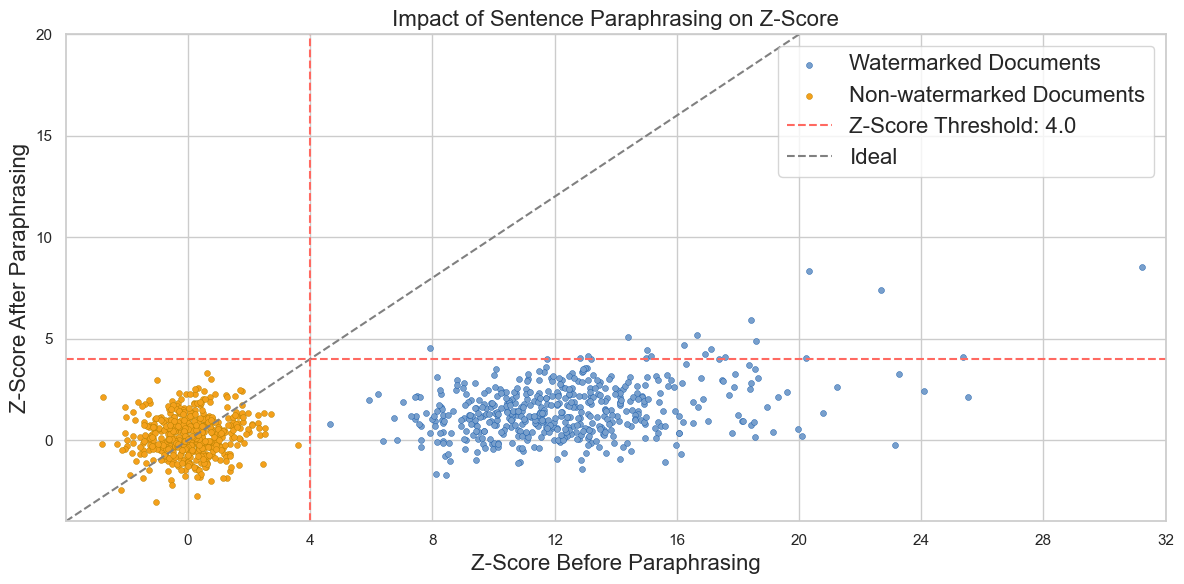

In [130]:
z_threshold = 4.0
fig, axs = plt.subplots(figsize=(12, 6))
scores_before_wmarked = scores_df[scores_df["watermarked"] == 1]["z-score-before"]
scores_after_wmarked = scores_df[scores_df["watermarked"] == 1]["z-score-after"]

scores_before_nowm = scores_df[scores_df["watermarked"] == 0]["z-score-before"]
scores_after_nowm = scores_df[scores_df["watermarked"] == 0]["z-score-after"]


sns.scatterplot(x=scores_before_wmarked, y=scores_after_wmarked, ax=axs, color='#789FCC', edgecolor="#1E60AD", s=18, label='Watermarked Documents')
sns.scatterplot(x=scores_before_nowm, y=scores_after_nowm, ax=axs, color='#f4a01b', edgecolor="#b98201", s=18, label='Non-watermarked Documents')

axs.set_xlabel("Z-Score Before Paraphrasing", fontsize=16)
axs.set_ylabel("Z-Score After Paraphrasing", fontsize=16)

left = min(0, np.min(scores_before)-1)
right = max(scores_before)+1
bottom = min(0, np.min(scores_after)-1)
top = max(scores_after) + 1

axs.set_xlim(left=-4, right=32)
axs.set_ylim(bottom=-4, top=20)
axs.axhline(z_threshold, label='Z-Score Threshold: 4.0', color='#FF6961', linestyle='--')
axs.axline((0,0), slope=1, linestyle='--', label='Ideal', color='gray')
axs.axvline(z_threshold, color='#FF6961', linestyle='--')

axs.set_xticks(list(range(0, np.ceil(right).astype(np.int32), 4)))

axs.set_title(f"Impact of {pp_names[type_index]} on Z-Score", fontsize=16)
axs.grid(which='minor')

plt.legend(fontsize=16)
plt.tight_layout()

# plt.savefig(f"{output_path}/{pp_names[type_index].lower()}.pdf", bbox_inches='tight', format='pdf', dpi=2400)

plt.show()